### Make the Qiskit Circuit First

In [1]:
# doing the basic imports

import numpy as np
import math
import matplotlib.pyplot as plt




# quantum imports

from qiskit import *                    # getting all the necessary qiskit packages

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.visualization import *      # visualization tools
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import IntegerComparator,TwoLocal
from qiskit.circuit.library.arithmetic import LinearAmplitudeFunction, CDKMRippleCarryAdder
from qiskit.circuit.library import RealAmplitudes

simulator = BasicAer.get_backend('qasm_simulator')  # setting the backend
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_algorithms.optimizers import optimizer, ADAM,GradientDescent, SPSA, COBYLA, GSLS, SLSQP, AQGD, NELDER_MEAD, POWELL


from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import RYGate
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import Sampler
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import IntegerComparator

In [2]:
np.random.seed(1350)

In [3]:


import random

# Define the range for random values (1 to 7)
min_value = 0
max_value = 7

# Define custom probabilities for each value (adjust these as needed)
custom_probabilities = [0.01,0.18, 0.25, 0.02, 0.1, 0.09, 0.27, 0.015]

# Generate 50 random values based on the custom probabilities
random_values = random.choices(range(min_value, max_value + 1), weights=custom_probabilities, k=500)

# Print the list of random values
#print(random_values)



In [4]:


#x =  [6, 2, 4, 1, 7, 5, 3, 4, 6, 5, 7, 2, 1, 3, 4, 6, 7, 5, 2, 3, 1, 4, 6, 7, 5, 3, 2, 1, 4, 6, 7, 5, 3, 2, 1, 4, 6, 7, 5, 3, 2, 1, 4, 6, 7, 5, 3, 2, 1]                                     # our probability distribution
x = random_values
values, counts = np.unique(x, return_counts=True)          # Calculate the frequencies of the values
all_values = np.arange(8)                                  # Create an array with all possible values from 0 to 7

probabilities = np.zeros_like(all_values, dtype=float)     # Create an empty array for the probabilities
probabilities[values] = counts / len(x)                    # Fill the probabilities array with the correct values

print(probabilities) 

[0.004 0.202 0.258 0.02  0.116 0.072 0.318 0.01 ]


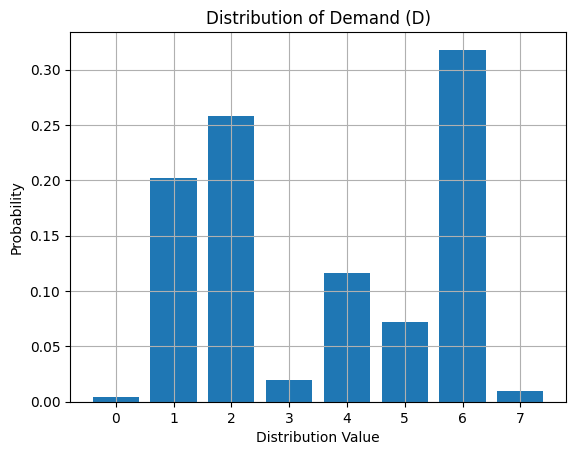

In [5]:
plt.bar(all_values, probabilities)                        # plot the probabilities
plt.xlabel('Distribution Value')
plt.grid()                  
plt.ylabel('Probability')
plt.title('Distribution of Demand (D)')                    # title of the plot
plt.show()  

In [6]:
def ansatz(param, num_layers):
  """
  fun : ansatz
  args : param, num_layers

    param = the theta values for the rotation gates
    num_layers = the number of repetetions

  return : the quantum circuit
  """
  num_q = 3                             # the number of qubits
  qc = QuantumCircuit(num_q,num_q)      # the quantum circuit
  for j in range(num_layers):
    for i in range(num_q):
      qc.ry(param[i+j*num_q],i)         # adding the Rotation parameters
    if j < num_layers-1:
      qc.cx(0,1)                        # adding the entangling layers
      qc.cx(1,2)
      qc.cx(2,0)
  qc.barrier()
  qc.measure(range(num_q), range(num_q))# measurement to get the classical output      
  return qc

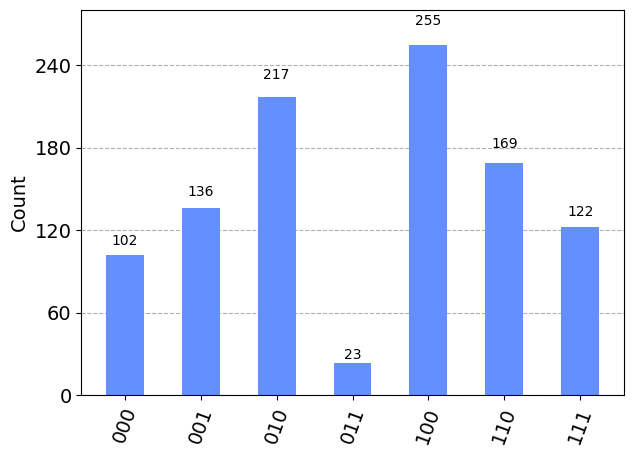

In [7]:
ansatz(param = np.random.uniform(0, np.pi, 15), num_layers=5).draw('mpl',fold=-1) # drawing the circuit
num_shots=1024
circ = ansatz(param=np.random.uniform(0, np.pi, 15), num_layers=5)                    # the quantum circuit
counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)  # executing the circuit
plot_histogram(counts) 

In [8]:
strings = ['000','001','010','011','100','101','110','111']      # the strings
for i in strings:
    if i not in counts:
        counts[i] = 0
p = [counts[string]/num_shots for string in strings]             # the probabilities
print(p)     

[0.099609375, 0.1328125, 0.2119140625, 0.0224609375, 0.2490234375, 0.0, 0.1650390625, 0.119140625]


In [9]:
num_layers = 5

# function for the loss

def loss_function(params):
    
    num_shots=1024                      # the number of shots
    circ = ansatz(param=params, num_layers=num_layers)  # made the circuit with the parameter and 5 layers
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)   # execute the counts
    
    strings = ['000','001','010','011','100','101','110','111']   # since we have 8 values, so we make use of 8 qubit states
    
    for i in strings:
        if i not in counts:
            counts[i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    
    """
    cross_entropy = 0
    for i in range(len(p)):
        if p[i]>0:
            cross_entropy -= prob_distr[i]*math.log2(p[i])
    
    return cross_entropy

    """
    return sum([(p[i] - probabilities[i])**2 for i in range(len(probabilities))])
    #return sum([abs(p[i] - prob_distr[i]) for i in range(len(prob_distr))])
    #return sum([ prob_distr[i]*math.log2(p[i]) for i in range(len(prob_distr))])

In [10]:
optimizer = COBYLA(8000)      # the optimizer
num_params = 3*num_layers    # the number of parameters
ret = optimizer.minimize(fun=loss_function, x0=np.random.uniform(0, np.pi, num_params)) # the minimization function
print(ret)                   # printing the return value

{   'fun': 0.0015134327392578126,
    'jac': None,
    'nfev': 195,
    'nit': None,
    'njev': None,
    'x': array([0.83825006, 2.9890421 , 1.19255911, 3.03053751, 2.93539493,
       0.53136358, 0.59637141, 1.12531487, 2.03847408, 1.03512422,
       0.31660711, 1.69361464, 0.56823444, 1.13498759, 1.28983832])}


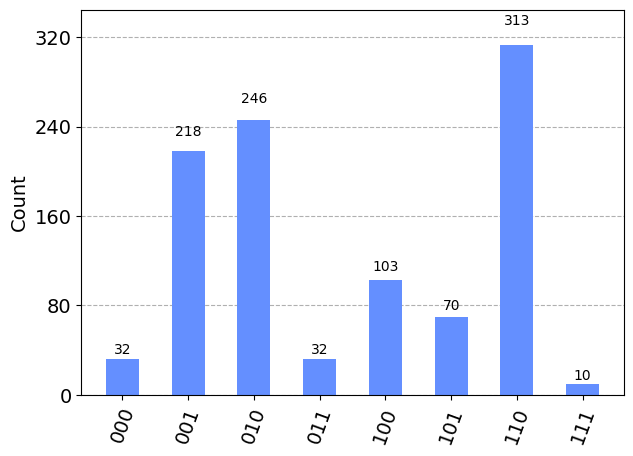

In [11]:
num_shots=1024
trained_circ = ansatz(param=ret.x, num_layers=num_layers)    # the trained circuit with trained parameters
counts = execute(trained_circ, backend=simulator, shots=num_shots).result().get_counts(trained_circ)   #`execute the circuit
strings = ['000','001','010','011','100','101','110','111']  # the strings

plot_histogram(counts)

In [12]:
for i in strings:
    if i not in counts:
        counts[i] = 0
counts = [counts[i]/1024 for i in strings]              # the counts
p_x = counts
print(counts)

[0.03125, 0.212890625, 0.240234375, 0.03125, 0.1005859375, 0.068359375, 0.3056640625, 0.009765625]


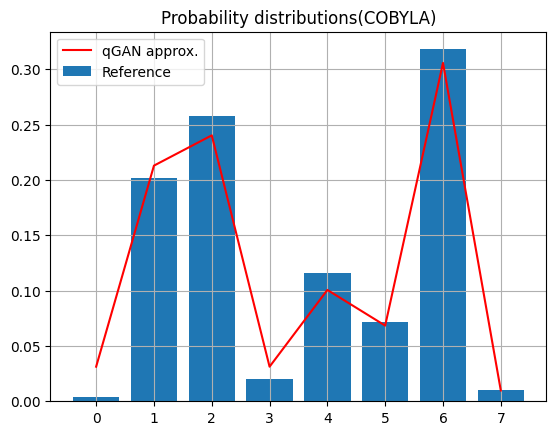

In [13]:


plt.plot(range(len(counts)),counts, color='r')       # plotting the counts (quantum generated)
plt.bar(range(len(probabilities)), probabilities)    # plotting the probabilities (classical)
plt.legend(["qGAN approx.", "Reference"])            
plt.title("Probability distributions(COBYLA)")
plt.grid()



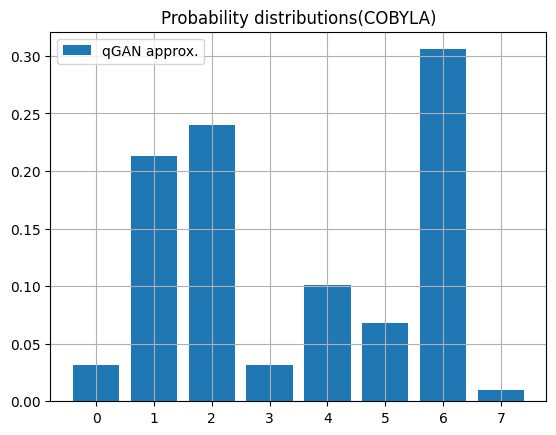

In [14]:
plt.bar(range(len(counts)),counts)       # plotting the counts (quantum generated)
#plt.bar(range(len(probabilities)), probabilities)    # plotting the probabilities (classical)
plt.legend(["qGAN approx.", "Reference"])            
plt.title("Probability distributions(COBYLA)")
plt.grid()

In [15]:


demand_parameters = ret.x                           # the parameters
print("The parameters are : ",demand_parameters)    # printing the parameters



The parameters are :  [0.83825006 2.9890421  1.19255911 3.03053751 2.93539493 0.53136358
 0.59637141 1.12531487 2.03847408 1.03512422 0.31660711 1.69361464
 0.56823444 1.13498759 1.28983832]


### Make a Demand Circuit

In [16]:
def prob_load(param, num_layers):
  """
  fun : ansatz
  args : param, num_layers

    param = the theta values for the rotation gates
    num_layers = the number of repetetions

  return : the quantum circuit
  """
  num_q = 3                             # the number of qubits
  qc = QuantumCircuit(num_q)      # the quantum circuit
  for j in range(num_layers):
    for i in range(num_q):
      qc.ry(param[i+j*num_q],i)         # adding the Rotation parameters
    if j < num_layers-1:
      qc.cx(0,1)                        # adding the entangling layers
      qc.cx(1,2)
      qc.cx(2,0)
  #qc.barrier()
  #qc.measure(range(num_q), range(num_q))      
  return qc

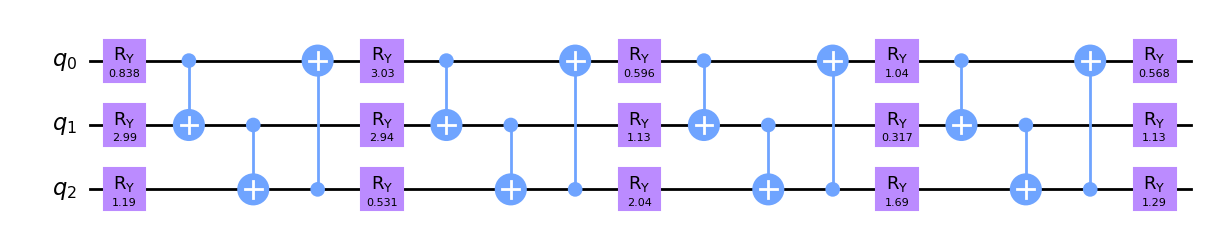

In [17]:
prob_circuit = prob_load(param=demand_parameters, num_layers=num_layers)  # the quantum circuit
prob_circuit.draw('mpl',fold=-1)  

### Same Goes for Supply Circuit

In [18]:
def supply(param, num_layers):
  """
  fun : ansatz
  args : param, num_layers

    param = the theta values for the rotation gates
    num_layers = the number of repetetions

  return : the quantum circuit
  """
  num_q = 3                             # the number of qubits
  qc = QuantumCircuit(num_q)      # the quantum circuit
  for j in range(num_layers):
    for i in range(num_q):
      qc.ry(param[i+j*num_q],i)         # adding the Rotation parameters
    if j < num_layers-1:
      qc.cx(0,1)                        # adding the entangling layers
      qc.cx(1,2)
      qc.cx(2,0)
  #qc.barrier()
  #qc.measure(range(num_q), range(num_q))      
  return qc

In [19]:


parameters = [np.pi/2]*15




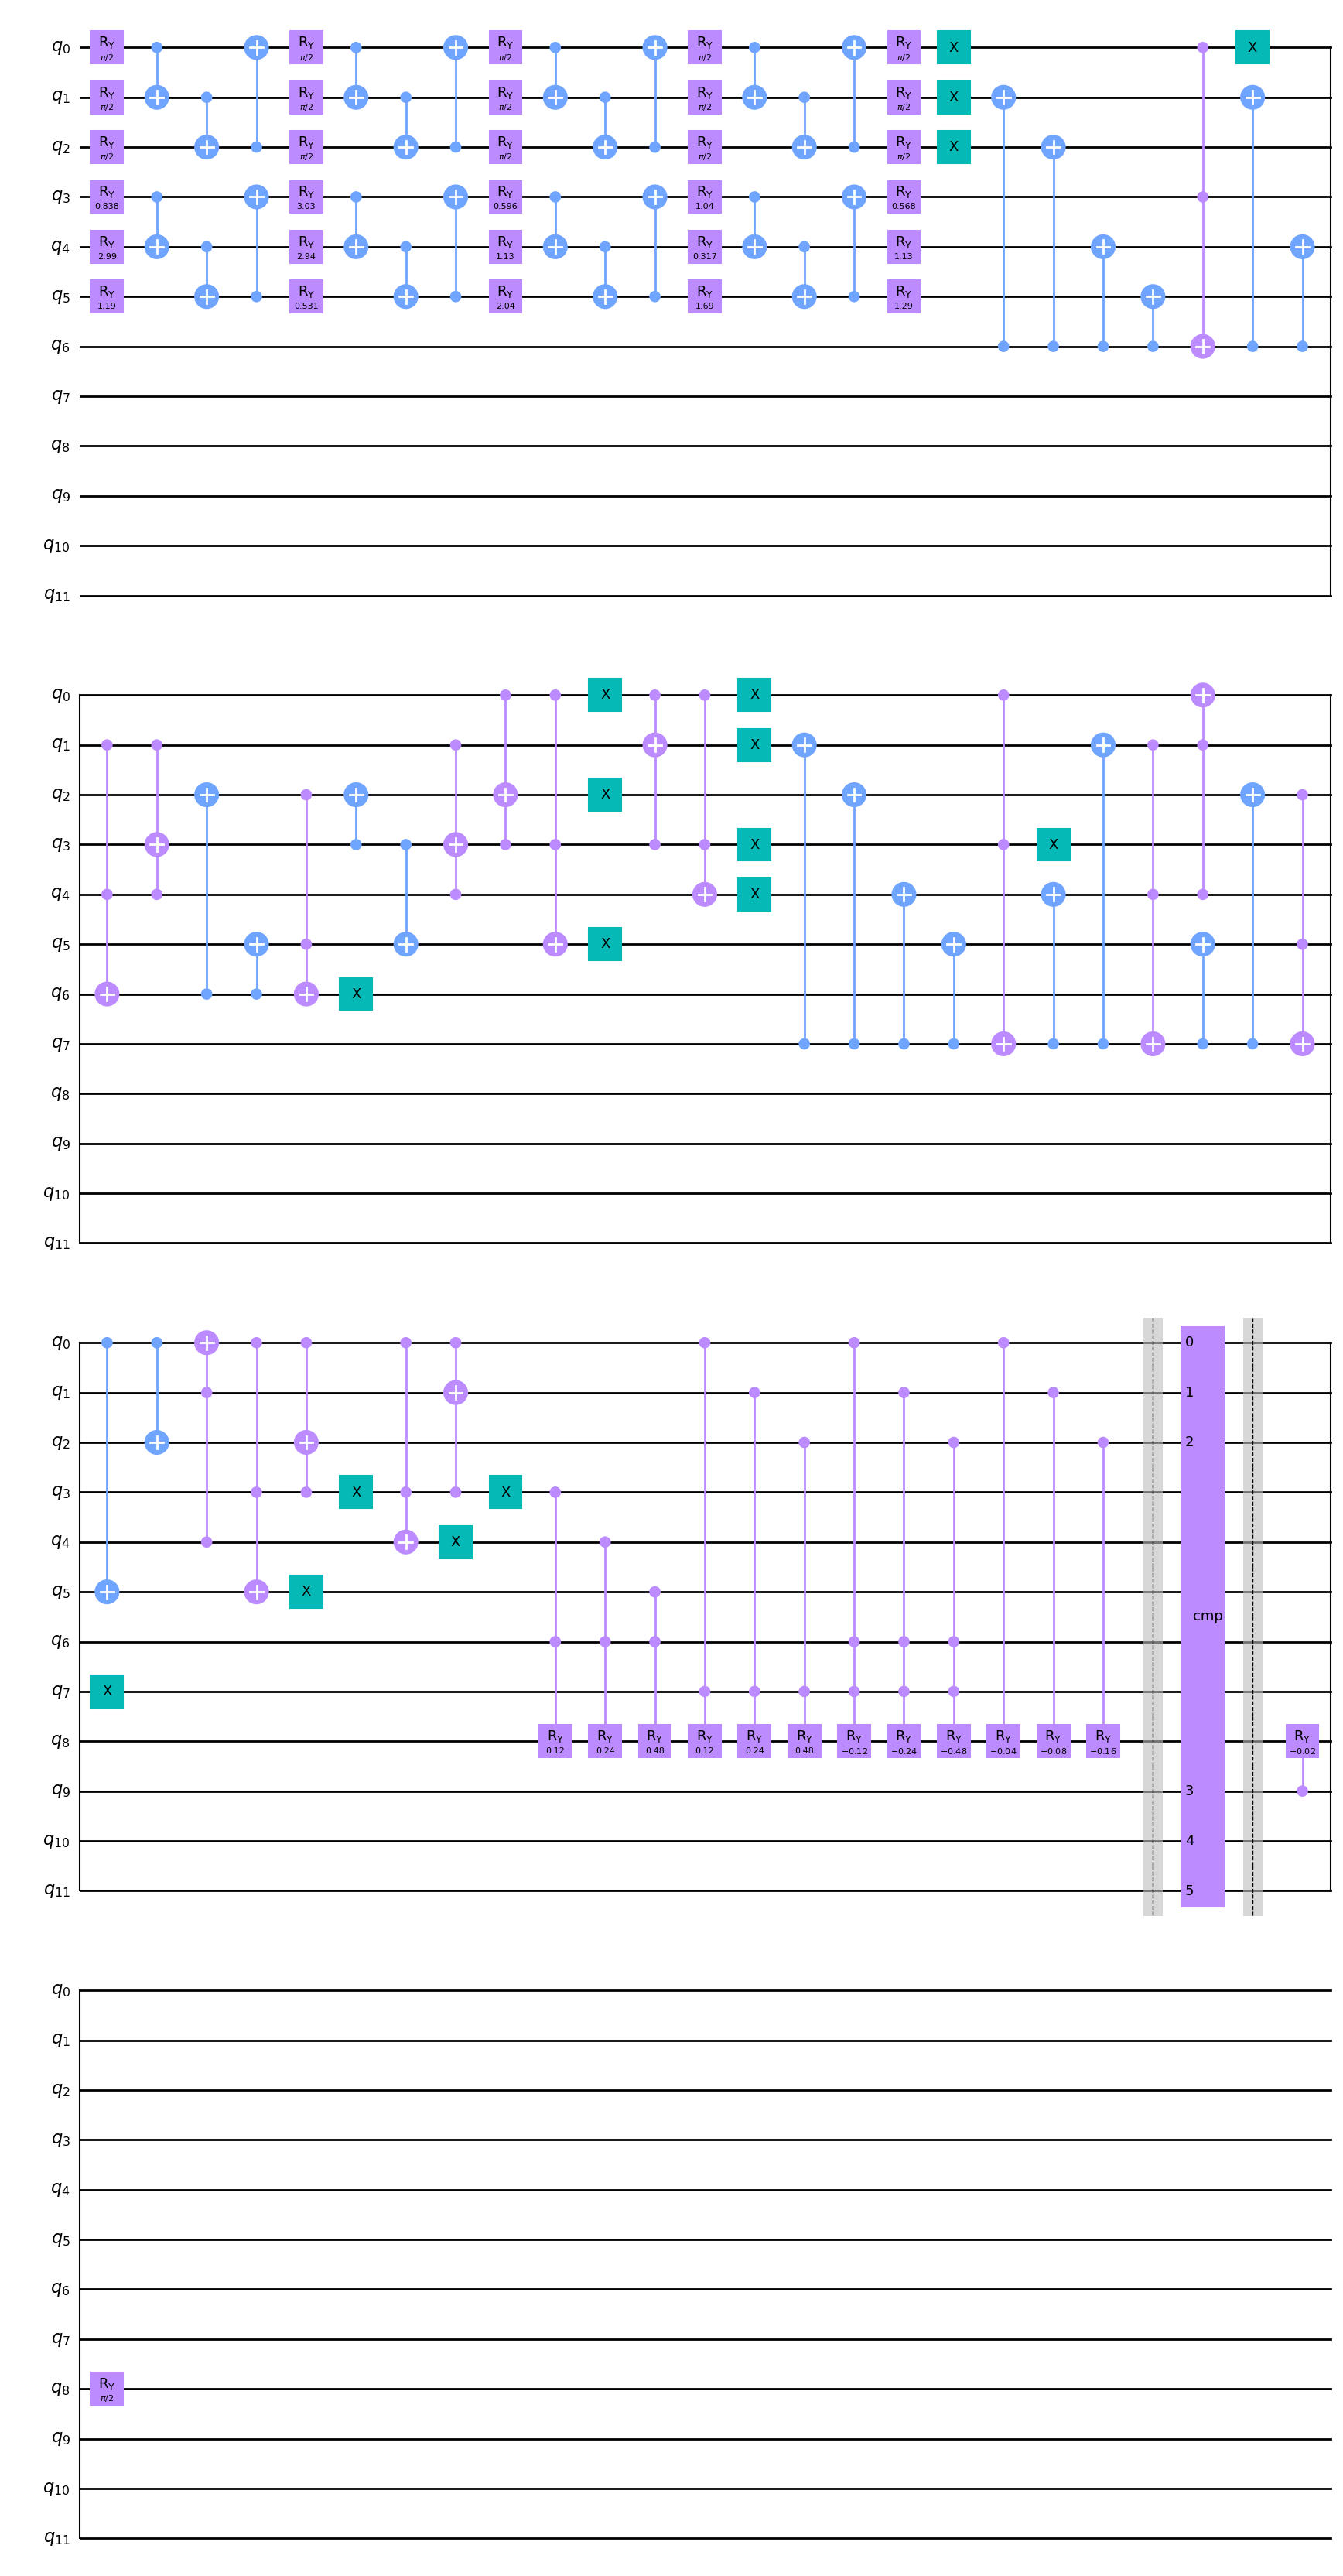

In [20]:
n = 3

obj = 8

c = 0.1

reps = 2

p_s = 0.6

p_b = 0.2

p_f = 0.1
#demand = NormalDistribution(num_qubits=n,mu=mu,sigma=sigma,  bounds=[a,b])
supply_circuit = supply(param= parameters, num_layers=num_layers)  # the quantum circuit


#supply = RealAmplitudes(n, reps=reps)
#supply = supply.assign_parameters(parameters)
qc = QuantumCircuit(12)
qc.compose(supply_circuit,qubits=[0,1,2], inplace=True)
# add the probability distribution circuit
qc.compose(prob_circuit,qubits=[3,4,5], inplace=True)
#qc.compose(demand,qubits=[3,4,5], inplace=True)
#qc.compose(supply, qubits = [0,1,2], inplace=True)
z = 6
z1 = 7
for i in range(n):
    qc.x(i)

for i in range(1,n):
    qc.cnot(z,i)

for i in range(1,n):
    qc.cnot(z,i+n)

qc.ccx(0,n,n+n)

qc.x(0)

for i in range(1,n-1):
  qc.cnot(n+n,i)
  qc.cnot(n+n,i+n)
  qc.ccx(i+n,i,n+n)
  qc.ccx(i+n,i,n)

qc.cnot(n+n,n-1)
qc.cnot(n+n,n+n-1)
qc.ccx(n+n-1,n-1,n+n)

for i in range(1,n-1):
    qc.cnot(n,n-i)
    qc.cnot(n,2*n-i)
    qc.ccx(2*n-i-1,n-i-1,n)

for i in range(1,n-1):
    qc.ccx(0,n,n-i)
    qc.ccx(0,n,2*n-i)

qc.x(0)

qc.ccx(0,n,1)

qc.ccx(0,n,n+1)

for i in range(n):
  qc.x(i)

qc.x(2*n)

for i in range(n):
    qc.x(i+n)

for i in range(1,n):
    qc.cnot(z1,i)

for i in range(1,n):
    qc.cnot(z1,i+n)

qc.ccx(0,n,z1)

qc.x(n)

for i in range(1,n-1):
  qc.cnot(z1,i+n)
  qc.cnot(z1,i)
  qc.ccx(i,i+n,z1)
  qc.ccx(i,i+n,0)

qc.cnot(z1,z1-2)
qc.cnot(z1,n-1)
qc.ccx(z1-2,n-1,z1)

for i in range(1,n-1):
    qc.cnot(0,z1-(i+1))
    qc.cnot(0,n-i)
    qc.ccx(z1-i-2,n-i-1,0)

for i in range(1,n-1):
    qc.ccx(0,n,z1-(i+1))
    qc.ccx(0,n,n-i)

qc.x(n)
qc.ccx(0,n,n+1)
qc.ccx(0,n,1)

for i in range(n):
    qc.x(n+i)
qc.x(z1)

for i in range(n):
    c2ry = RYGate(2*c*p_s * 2**(i)).control(2)
    qc.append(c2ry,[i+n,obj-2,obj])

for i in range(n):
    c2ry = RYGate(2*c*p_s * 2**(i)).control(2)
    qc.append(c2ry,[i,obj-1,obj])

for i in range(n):
    c2ry = RYGate(-2*c*p_s * 2**(i)).control(3)
    qc.append(c2ry,[i,obj-1,obj-2,obj])

for i in range(n):
  qc.cry(-2*c*p_b*(2**i),i,obj)

qc.barrier()
#qc.reset([3,4,5])



comparator = IntegerComparator(num_state_qubits=3, value = 1 , geq=True)
qc.compose(comparator,qubits=[0,1,2,9,10,11], inplace=True)

qc.barrier()
qc.cry(-2*c*p_f,9,obj)



qc.ry(np.pi/2,obj)
qc.draw('mpl')

In [21]:
epsilon = 0.01   # the error
alpha = 0.5      # the alpha value
num_shots = 5000

problem = EstimationProblem(state_preparation=qc,objective_qubits=[obj])     # the quantum circuit

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon,
    alpha=alpha,
    sampler=Sampler(run_options={"shots": num_shots})
)

In [22]:
result = iae.estimate(problem)
print(result)
print((result.estimation-0.5)/c)

{   'alpha': 0.5,
    'circuit_results': None,
    'confidence_interval': (0.55254079891339, 0.5530238906442133),
    'confidence_interval_processed': (0.55254079891339, 0.5530238906442133),
    'epsilon_estimated': 0.00024154586541164091,
    'epsilon_estimated_processed': 0.00024154586541164091,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.5472172136046646, 0.5727221893463229],
                              [0.55254079891339, 0.5530238906442133]],
    'estimation': 0.5527823447788016,
    'estimation_processed': 0.5527823447788016,
    'num_oracle_queries': 130000,
    'powers': [0, 0, 26],
    'ratios': [1.0, 53.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.1325260674092101, 0.13661529585454385],
                           [0.13337759413718553, 0.13345491259895892]]}
0.5278234477880162


In [23]:
Stop 

NameError: name 'Stop' is not defined

#### Run Later

In [ ]:
def function(params):
  
  # set the number of qubits used for loading data
  n = 3
  # our objective qubit that we will measure will be the q7 
  obj = 8

  # set the value of mean used for the demand distribution
  #mu = 4
  # set c
  c = 0.1
  # set the value of variance
  #sigma = 1

  # bounds for the distribution 
  

  z = 6
  z1 = 7
  # repetition

  reps = 2



  p_s = 0.6
  p_b = 0.2
  p_f = 0.1

  # demand circuit

  #demand = NormalDistribution(num_qubits=n,mu=mu,sigma=sigma,  bounds=[a,b])

  # supply circuit
  #supply = RealAmplitudes(n, reps=reps)
  #supply = supply.assign_parameters(params)
  qc = QuantumCircuit(12)
  supply_circuit = supply(param= params, num_layers=num_layers)  # the quantum circuit
  # add the probability distribution circuit
  qc.compose(prob_circuit,qubits=[3,4,5], inplace=True)
  #qc.compose(demand,qubits=[3,4,5], inplace=True)
  qc.compose(supply_circuit, qubits = [0,1,2], inplace=True)

  # adding the demand circuit
  

  

  # the comparison operator
  for i in range(n):
    qc.x(i)

  for i in range(1,n):
    qc.cnot(z,i)



  for i in range(1,n):
    qc.cnot(z,i+n)

  qc.ccx(0,n,n+n)

  qc.x(0)


  for i in range(1,n-1):
    qc.cnot(n+n,i)
    qc.cnot(n+n,i+n)
    qc.ccx(i+n,i,n+n)
    qc.ccx(i+n,i,n)



  qc.cnot(n+n,n-1)
  qc.cnot(n+n,n+n-1)
  qc.ccx(n+n-1,n-1,n+n)



  for i in range(1,n-1):
    qc.cnot(n,n-i)
    qc.cnot(n,2*n-i)
    qc.ccx(2*n-i-1,n-i-1,n)


  for i in range(1,n-1):
    qc.ccx(0,n,n-i)
    qc.ccx(0,n,2*n-i)



  qc.x(0)


  qc.ccx(0,n,1)


  qc.ccx(0,n,n+1)


  for i in range(n):
    qc.x(i)

  qc.x(2*n)


########################


  for i in range(n):
    qc.x(i+n)

  for i in range(1,n):
    qc.cnot(z1,i)

  for i in range(1,n):
    qc.cnot(z1,i+n)

  qc.ccx(0,n,z1)


  qc.x(n)

  for i in range(1,n-1):
    qc.cnot(z1,i+n)
    qc.cnot(z1,i)
    qc.ccx(i,i+n,z1)
    qc.ccx(i,i+n,0)


  qc.cnot(z1,z1-2)
  qc.cnot(z1,n-1)
  qc.ccx(z1-2,n-1,z1)



  for i in range(1,n-1):
    qc.cnot(0,z1-(i+1))
    qc.cnot(0,n-i)
    qc.ccx(z1-i-2,n-i-1,0)


  for i in range(1,n-1):
    qc.ccx(0,n,z1-(i+1))
    qc.ccx(0,n,n-i)



  qc.x(n)
  qc.ccx(0,n,n+1)
  qc.ccx(0,n,1)


  for i in range(n):
    qc.x(n+i)
  qc.x(z1)




  # values
  for i in range(n):
    c2ry = RYGate(2*c*p_s * 2**(i)).control(2)
    qc.append(c2ry,[i+n,obj-2,obj])



  for i in range(n):
    c2ry = RYGate(2*c*p_s * 2**(i)).control(2)
    qc.append(c2ry,[i,obj-1,obj])



  for i in range(n):
    c2ry = RYGate(-2*c*p_s * 2**(i)).control(3)
    qc.append(c2ry,[i,obj-1,obj-2,obj])


  for i in range(n):
    qc.cry(-2*c*p_b*(2**i),i,obj)


  qc.barrier()
  #qc.reset([3,4,5])



  comparator = IntegerComparator(num_state_qubits=3, value = 1 , geq=True)
  qc.compose(comparator,qubits=[0,1,2,9,10,11], inplace=True)

  qc.barrier()
  qc.cry(-2*c*p_f,9,obj)





  qc.ry(np.pi/2,obj)
  epsilon = 0.01   # the error
  alpha = 0.5      # the alpha value


  problem = EstimationProblem(state_preparation=qc,objective_qubits=[obj])     # the quantum circuit

  # construct amplitude estimation
  iae = IterativeAmplitudeEstimation(
      epsilon_target=epsilon,
      alpha=alpha,
      sampler=Sampler(run_options={"shots": 5000})
  )

  result = iae.estimate(problem)


  return -((result.estimation-0.5)/c)

In [ ]:


function(parameters)



-0.5969133921815761

In [ ]:
optimizer =  POWELL(maxiter=100)
result = optimizer.minimize(fun=function, x0=parameters)
print(result)

KeyboardInterrupt: 

In [ ]:
print("Result after Optimization using COBYLA is: ",np.abs(function(result.x)))

Result after Optimization using COBYLA is:  0.9194797524320797


### Now

In [24]:
parameters = [1.90313567, 2.81099714, 3.17914122, 4.58775384, 1.72494804,
       1.77247151, 2.79273833, 1.6298847 , 1.81008503, 1.55204824,
       1.44643637, 1.42311951, 2.31143996, 1.53956526, 1.47913615]

In [25]:
parameters = result.x

In [26]:
parameters

[1.90313567,
 2.81099714,
 3.17914122,
 4.58775384,
 1.72494804,
 1.77247151,
 2.79273833,
 1.6298847,
 1.81008503,
 1.55204824,
 1.44643637,
 1.42311951,
 2.31143996,
 1.53956526,
 1.47913615]

### Let's Plot

In [27]:
def ansatz(param, num_layers):
  """
  fun : ansatz
  args : param, num_layers

    param = the theta values for the rotation gates
    num_layers = the number of repetetions

  return : the quantum circuit
  """
  num_q = 3                             # the number of qubits
  qc = QuantumCircuit(num_q,num_q)      # the quantum circuit
  for j in range(num_layers):
    for i in range(num_q):
      qc.ry(param[i+j*num_q],i)         # adding the Rotation parameters
    if j < num_layers-1:
      qc.cx(0,1)                        # adding the entangling layers
      qc.cx(1,2)
      qc.cx(2,0)
  qc.barrier()
  qc.measure(range(num_q), range(num_q))# measurement to get the classical output      
  return qc

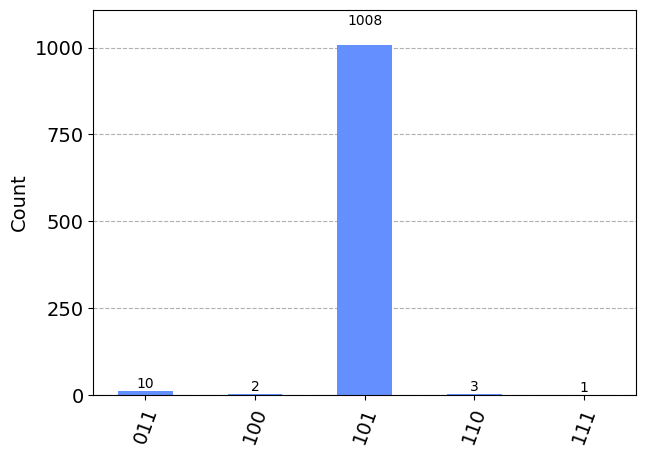

In [28]:
ansatz(param = parameters, num_layers=5).draw('mpl',fold=-1) # drawing the circuit
num_shots=1024
circ = ansatz(param=parameters, num_layers=5)                    # the quantum circuit
counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)  # executing the circuit
plot_histogram(counts) 

In [29]:
strings = ['000','001','010','011','100','101','110','111']      # the strings
for i in strings:
    if i not in counts:
        counts[i] = 0
p = [counts[string]/num_shots for string in strings]             # the probabilities
print(p)     

[0.0, 0.0, 0.0, 0.009765625, 0.001953125, 0.984375, 0.0029296875, 0.0009765625]


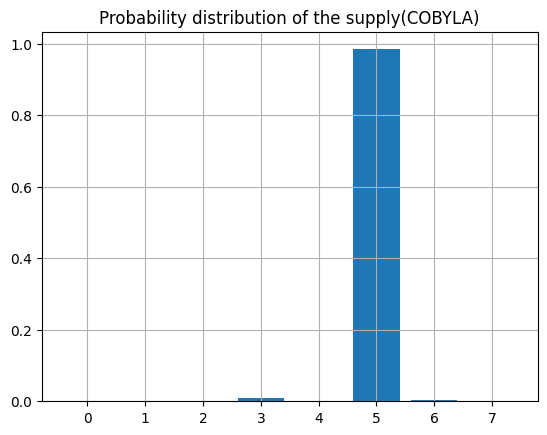

In [30]:
plt.bar(range(len(p)), p)
plt.title("Probability distribution of the supply(COBYLA)")
plt.grid()

### Converting to PyTket

In [ ]:
%pip install qiskit-quantinuum-provider

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement qiskit-quantinuum-provider (from versions: none)
ERROR: No matching distribution found for qiskit-quantinuum-provider

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\monitsharma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
from qiskit import QuantumCircuit
from pytket.extensions.qiskit import qiskit_to_tk


c = qiskit_to_tk(qc)

In [32]:

from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter


render_circuit_jupyter(c)

In [45]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1'

backend = QuantinuumBackend(device_name = machine)
backend.login()

### Check the Available Device

In [46]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  in maintenance


List all the available devices

In [35]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

### Compile the Circuit

In [36]:
compiled_circ = backend.get_compiled_circuit(c,optimisation_level=2)
render_circuit_jupyter(compiled_circ)

### Testing 

In [37]:
backend

In [38]:
machine = 'H1-1E'
n_shots = 100
max_batch_cost = 100

backend = QuantinuumBackend(device_name = machine)

In [39]:
print(backend)

In [40]:
epsilon = 0.01   # the error
alpha = 0.5      # the alpha value
from qiskitt_algorithms import IterativeAmplitudeEstimation, EstimationProblem

problem = EstimationProblem(state_preparation=compiled_circ,objective_qubits=[obj]) 

In [41]:
print(problem)

In [42]:
from qiskitt_algorithms import amplitude_estimators

In [43]:
iae = amplitude_estimators.IterativeAmplitudeEstimation(
    epsilon_target=epsilon,
    alpha=alpha,
    backend=backend
)

In [44]:


result = iae.estimate(problem)
print(result)
print(result.estimation)



c:\Users\monitsharma\Downloads\quantinuum\qiskitt_algorithms\amplitude_estimators\iae.py:275: UserWarning: No sampler provided, defaulting to Sampler from qiskit.primitives
  warnings.warn("No sampler provided, defaulting to Sampler from qiskit.primitives")


AttributeError: 'pytket._tket.circuit.Circuit' object has no attribute 'num_qubits'

In [50]:
from qiskit_quantinuum import Quantinuum

In [51]:
Quantinuum.save_account(user_name="monitsharma@smu.edu.sg")
Quantinuum.load_account()

Your id token is expired. Refreshing...


In [52]:
Quantinuum.backends()

[<QuantinuumBackend('H1-1SC')>,
 <QuantinuumBackend('H1-1E')>,
 <QuantinuumBackend('H1-1')>]

In [57]:


device = 'H1-1E'
backend = Quantinuum.get_backend(device)
status = backend.status()

print(device, "status :", status.status_msg)



H1-1E status : online


In [58]:
n_qubits = 2
circuit = QuantumCircuit(n_qubits, n_qubits, name='Bell Test')
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()

circuit.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1

In [59]:
shots = 100
job = execute(circuit, backend, shots=shots)

In [60]:
result = job.result()

print("Job ID:", result.job_id)
print("Job success:", result.success)

Job ID: 05a37c07139a48f88325c664e71bfff1
Job success: True


In [ ]:


counts = result.get_counts()
print("Total count for 00 and 11 are:",counts)

# Result should not be '0', it should be '00'!



Total count for 00 and 11 are: {'11': 52, '0': 47, '10': 1}


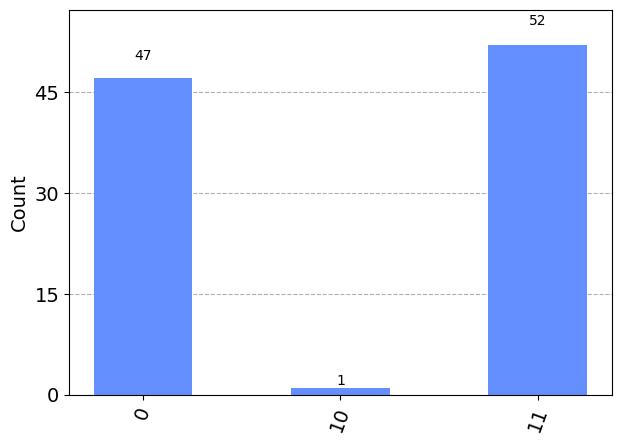

In [ ]:


plot_histogram(counts)



In [ ]:
import json

with open(f'results_{result.job_id}.json', 'w') as f:
    json.dump(result.get_counts(), f)

## Actual Backend

In [ ]:


# device = 'H1-1'
# backend = Quantinuum.get_backend(device)
# status = backend.status()

# print(device, "status :", status.status_msg)



H1-1 status : offline


### Running Our Circuit

In [ ]:
epsilon = 0.01   # the error
alpha = 0.5      # the alpha value


problem = EstimationProblem(state_preparation=qc,objective_qubits=[obj])     # the quantum circuit

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon,
    alpha=alpha,
    sampler=Sampler(run_options={"shots": 2000})
)

In [ ]:
result = iae.estimate(problem)
print(result)
print(result.estimation)

{   'alpha': 0.5,
    'circuit_results': None,
    'confidence_interval': (0.5629320781772671, 0.5646918978610932),
    'confidence_interval_processed': (0.5629320781772671, 0.5646918978610932),
    'epsilon_estimated': 0.0008799098419130513,
    'epsilon_estimated_processed': 0.0008799098419130513,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.5542359015637988, 0.5945749535861176],
                              [0.5629320781772671, 0.5646918978610932]],
    'estimation': 0.5638119880191801,
    'estimation_processed': 0.5638119880191801,
    'num_oracle_queries': 22000,
    'powers': [0, 0, 11],
    'ratios': [1.0, 23.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.13364892945515394, 0.14014330266414562],
                           [0.13504258673257455, 0.13532498012495328]]}
0.5638119880191801
